# Compute energy levels of Hydrogen Atom with Gaussian Linear Combination of Atomic Orbitals 


Here we will calculate a linear combination of atomic orbitals (LCAO) for the Hydrogen atom. Slater orbitals are exact in this case, so let's try a Gaussian orbital to demonstrate the procedure. 


### Import path and add our software

In [1]:
import os
import sys
import scipy.optimize
import matplotlib.pyplot as plt

### Add the cpt BFGS minimization, initialize constants for 2 Gaussians

In [2]:
import numpy as np

# physical constants
hbar = 1.0                  # Planck's constant / 2pi
m = 1.0                     # electron mass
e = 1.0                     # proton charge

# LCAO variational wave function
# psi = sum( d_i g(alpha_i, r) ) for i = 0, 1, 2, ...
# assume d_0 = 1 and vary alpha_0, d_1, alpha_1, d_2, alpha_2, ...
# vector of variational parameters
p = np.array([ 1.0, 1.0, 1.0, 0.5 ])       # initial guess for [ d_0, alpha_0, d_1, alpha_1 ]
accuracy = 1.0e-6           # desired accuracy for numerical operations

### Define the g function, matrix elements, minimization function and derivative

In [3]:
class LCAOGauss:
    def __init__(self, p):
        self.d = p[0::2]
        self.alpha = p[1::2]        
        self.ii = np.arange(len(self.alpha))
        self.jj = np.arange(len(self.alpha))
        self.i, self.j = np.meshgrid(self.ii,self.jj)        

    def Sij(self):  # matrix elements of S
        return (np.pi / (self.alpha[self.i] + self.alpha[self.j]))**(3.0/2.0)

    def Tij(self):  # matrix elements of T
        return (3.0 * hbar**2 / m * self.alpha[self.i] * self.alpha[self.j] *
                np.pi**(3.0/2.0) / (self.alpha[self.i] + self.alpha[self.j])**(5.0/2.0))
    
    def Vij(self):  # matrix elements of V
        return - 2.0 * e**2 * np.pi / (self.alpha[self.i] + self.alpha[self.j])

    def E(self):            # energy as function of N alpha_i and d_i
        S = H = 0.0        
        fac = (self.alpha[self.i] * self.alpha[self.j])**(3.0/4.0)* self.d[self.i] * self.d[self.j]
        Hvals = fac * (self.Tij() + self.Vij() )
        Svals = fac * self.Sij()
        H = np.sum(Hvals)
        S = np.sum(Svals)
        return H / S

    def __call__(self, p):                # function for BFGS minimization
        # assume p = [ d0, alpha_0, d_1, alpha_1, d_2, alpha_2, ... ]
        self.alpha = np.where( p[1::2] > accuracy, p[1::2], accuracy)
        self.d = p[::2]    
        e = self.E()
        return e

    def norm(self):                # norm of LCAO
        Sijvals = self.Sij() * self.d[self.i] * self.d[self.j]
        return np.linalg.norm(Sijvals)

    def psi(self, r): # Actual wave function psi(r)
        def gs(alpha, r1):
            return (2 * alpha / np.pi)**(0.75) * np.exp(-1. * alpha * r1**2)
            
        return (self.d[0] * gs(self.alpha[0], r) + self.d[1] * gs(self.alpha[1], r))

    def local_E(self, r):
        def gs(alpha, r1):
            return (2 * alpha / np.pi)**(0.75) * np.exp(-1. * alpha * r1**2)
            
        num = sum([self.d[i] * (3 * self.alpha[i] - 2 * self.alpha[i] * r**2 - 1. / r) * gs(self.alpha[i], r) for i in range(2)])
        den = self.psi(r)
        return num / den

### Drive the simulation

In [4]:
print(" Variational method for Hydrogen using Gaussian LCAO")
print(" Minimize <psi|H|psi>/<psi|psi> using BFGS algorithm")
lcao = LCAOGauss(p)
lcao(p)
res = scipy.optimize.minimize(lcao, p, tol=accuracy)
alpha = res.x[1::2]
d = res.x[::2]
A = lcao.norm()
d /= A

print(f"E={lcao.E():.5f}")

print(f"{'i':<3}{'alpha':<8}{'d':<8}")
for i in range(len(alpha)):
    print(f"{i:<3}{alpha[i]:<6.5f} {d[i]:<6.5f}")


 Variational method for Hydrogen using Gaussian LCAO
 Minimize <psi|H|psi>/<psi|psi> using BFGS algorithm
E=-0.48581
i  alpha   d       
0  1.33250 0.01072
1  0.20153 0.03208


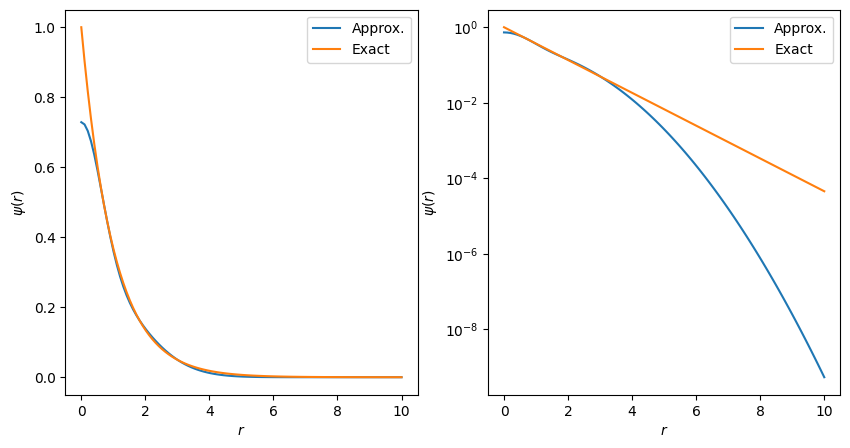

In [5]:
# Plot minimized wave function vs. true wave function

xx = np.linspace(0, 10, 100)
y_approx = lcao.psi(xx)
y_exact = np.exp(-1 * xx)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(xx, y_approx, label="Approx.")
ax[0].plot(xx, y_exact, label="Exact")
ax[0].set_yscale("linear")
ax[0].set_xlabel("$r$")
ax[0].set_ylabel(r"$\psi(r)$")
ax[0].legend()
ax[1].plot(xx, y_approx, label="Approx.")
ax[1].plot(xx, y_exact, label="Exact")
ax[1].set_yscale("log")
ax[1].set_xlabel("$r$")
ax[1].set_ylabel(r"$\psi(r)$")
ax[1].legend()

/tmp/ipykernel_1388/121411105.py:49: RuntimeWarning: divide by zero encountered in divide
  num = sum([self.d[i] * (3 * self.alpha[i] - 2 * self.alpha[i] * r**2 - 1. / r) * gs(self.alpha[i], r) for i in range(2)])


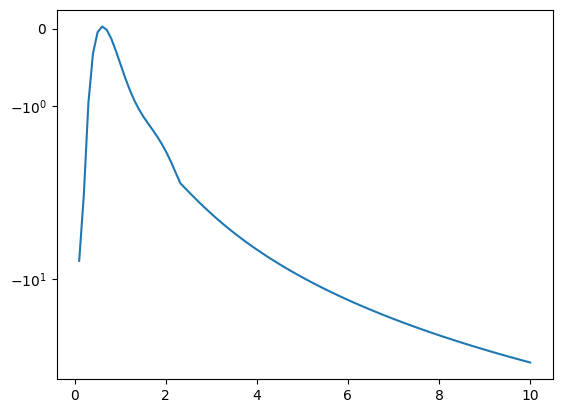

In [6]:
# Plot local E
xx = np.linspace(0, 10, 100)
local_E = lcao.local_E(xx)
plt.plot(xx, local_E)
plt.yscale("symlog")
